# TP4 CompStat - LACOMBE Yoach


---


## Exercise 1

### Question 1

In [ ]:
from scipy.stats import norm
import scipy
import numpy as np
import matplotlib.pyplot as plt



def draw_from_normal_distr(shape, mu, sigma):
  rv = scipy.stats.norm(loc = mu, scale = sigma)
  return rv.rvs(shape)


def log_likelihood(x,y, a = 10):
  '''
  Log Likelihood of the target distribution of 1.A
  '''
  lg = -(x/a)**2 - y**2 -((x/a)**2 - y**2)**2/4
  return lg

In [ ]:
def log_likelihood(vector, a = 10):
  '''
  Log Likelihood of the target distribution of 1.A (vectorized).
  '''
  x, y = vector
  lg = -(x/a)**2 - y**2 -((x/a)**2 - y**2)**2/4
  return lg

class MH_Sampler():
  '''
  Metropoling Hasting step associated to the targeted distribution 1.A.
  '''
  def __init__(self, init_values, sigma, a = 10):
    '''
    init_values = [x,y]
    '''
    self.vector = init_values
    self.sigma = [sigma]*len(init_values)
    self.compteur_acceptance = np.zeros_like(init_values)
    self.a = a
    self.compteur = np.zeros_like(init_values)
    self.lg = self.log_likelihood(self.vector)

  def log_likelihood(self, vector):
    return log_likelihood(vector, self.a)
    

  def reinitialisation(self, vector, sigma):
    self.vector = vector
    self.sigma = sigma
    self.compteur = np.zeros_like(vector)
    self.compteur_acceptance = np.zeros_like(vector)
    self.lg = self.log_likelihood(self.vector)

  
  def sample(self, index):
    vector = self.vector.copy()
    vector[index] = draw_from_normal_distr(1, vector[index], self.sigma[index])

    return vector
  

  def step(self, index):
    '''
    index: 0 -> x, 1 ->y
    '''
    #sample
    vector = self.sample(index)


    #acceptance_rejectance
    lg = self.lg
    lg_proposal = self.log_likelihood(vector)

    alpha = min(0, (lg_proposal - lg))
    
    u = np.log(np.random.uniform())
    #acceptance
    if u<=alpha:
      self.compteur_acceptance[index] += 1
      self.vector = vector
      self.lg = lg_proposal
    
    self.compteur[index] += 1

    return self.vector

In [ ]:
import pandas as pd

#taken from https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

class Sampler():
  def __init__(self, vector , sigma, a = 10):
    '''
    Sampling Algorithm.
    '''
    self.sampler = MH_Sampler(vector, sigma, a)
    self.vector = vector
    self.sigma = [sigma]*len(vector)

    self.history = [vector]
    self.history_alpha = {i: [] for i in range(len(vector))}
    

  def sample(self, nb_iterations_sampling = 100, nb_iterations_sampler = 100):
    for i in range(nb_iterations_sampler):
      index = np.random.randint(0, len(self.vector))
      for j in range(nb_iterations_sampling):
        self.sampler.step(index)
      self.vector = self.sampler.vector
      self.history_alpha[index].append(self.sampler.compteur_acceptance[index]/self.sampler.compteur[index])


      self.history.append(self.vector)

      self.sampler.reinitialisation(self.vector, self.sigma)

    return self.vector

  def plot_history(self):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))


    s_y = pd.Series([l[1] for l in self.history])

    s_yy = [crosscorr(s_y, s_y, lag=i) for i in range(0, len(s_y))]
    ax[0].plot(s_yy, label='self y')
    #pd.plotting.autocorrelation_plot(s_y, ax = ax[0], label = 'self y')

    s_x = pd.Series([l[0] for l in self.history])

    s_xx = [crosscorr(s_x, s_x, lag=i) for i in range(0, len(s_x))]
    ax[0].plot(s_xx, label='self x')
    #pd.plotting.autocorrelation_plot(s_x, ax = ax[0], label = 'self x')

    s_xy = [crosscorr(s_x, s_y, lag=i) for i in range(0, len(s_y))]
    ax[0].plot(s_xy, label='cross x-y')


    ax[1].plot(self.history_alpha[0], label='x')
    ax[1].plot(self.history_alpha[1], label='y')
    ax[0].title.set_text('Cross-Correlation')
    ax[1].title.set_text('Acceptance Rate')

    ax[0].legend()
    ax[1].legend()



    plt.show()
            
        
    

#### Question 2

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


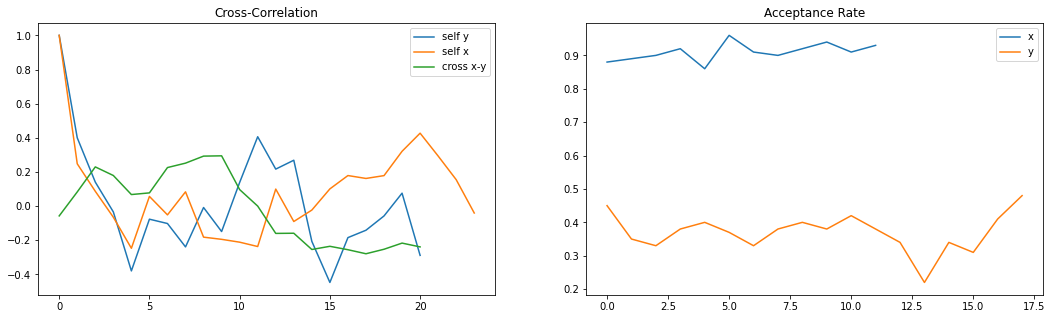

In [ ]:
sampler = Sampler(vector = np.array([0,0]), sigma = 3, a = 10)

sampled_x, sampled_y = sampler.sample(nb_iterations_sampling = 100, nb_iterations_sampler = 30)
sampler.plot_history()

As discussed in class, we see that if we really want to simulate independent draws from the distribution, the self-correlation should have a something positive at lags close to 0 and something relatively close to 0 at lags far from 0. It is no the case here, especially for the x coordinate.

It can be explained because the x-coordinate acceptance rate is too high (around 0.9 all along the algorithm iterations). In other words, the x-coordinate variance is too low and so the sampling jumps are really low and concentrate along the first samples. It means the sampling doesn't explore enough the distribution space alongside the x-coordinate.

The algorithm is thus underperforming.


#### Question 3

A first way would be to adapt the variance by hand. We know that the variance alongside the first dimension is greater than the variance of the second dimension, so without any artifices, we could set the constant variance of x greater than the variance of y, plot the acceptance rate and see if it is satisfactory. Then change a little bit more the variances. 

A second way of doing would be to normalize the target distribution (that is to make the variances equals to 1) in order not to have to adapt the variances. Of course, this method relies on knowing the variances, I don't if it is really doable. 

#### Question 1.B.1

In [ ]:

class AdaptativeSampler():
  def __init__(self, vector , initial_sigma = 3, goal_acceptance = 0.24, a = 10):
    self.sampler = MH_Sampler(vector, initial_sigma, a)
    self.vector = vector
    self.logsigma = np.array([np.log(initial_sigma)]*len(vector))


    self.goal_acceptance = 0.24

    self.history = [vector]
    self.history_alpha = {i: [] for i in range(len(vector))}
    

  def sample(self, nb_iterations_sampling = 100, nb_iterations_sampler = 100):
    for i in range(nb_iterations_sampler):
      index = np.random.randint(0, len(self.vector))
      for j in range(nb_iterations_sampling):
        self.sampler.step(index)
      self.vector = self.sampler.vector
      self.history_alpha[index].append(self.sampler.compteur_acceptance[index]/self.sampler.compteur[index])


      self.history.append(self.vector)


      self.update_logsigmas(i +1, index)

      self.sampler.reinitialisation(self.vector, np.exp(self.logsigma))

    return self.vector

  def update_logsigmas(self, batch, index):
    if len(self.history_alpha[index]) > 0 :
      if self.history_alpha[index][-1]> self.goal_acceptance:
        self.logsigma[index] += max(0.01, batch**(-1/2))
      else:
        self.logsigma[index] -= max(0.01, batch**(-1/2))



  def plot_history(self):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

    s_y = pd.Series([l[1] for l in self.history])

    s_yy = [crosscorr(s_y, s_y, lag=i) for i in range(0, len(s_y))]
    ax[0].plot(s_yy, label='self second coordinate')
    #pd.plotting.autocorrelation_plot(s_y, ax = ax[0], label = 'self y')

    s_x = pd.Series([l[0] for l in self.history])

    s_xx = [crosscorr(s_x, s_x, lag=i) for i in range(0, len(s_x))]
    ax[0].plot(s_xx, label='self first coordinate')
    #pd.plotting.autocorrelation_plot(s_x, ax = ax[0], label = 'self x')


    ax[1].plot(self.history_alpha[0], label='first coordinate')
    ax[1].plot(self.history_alpha[1], label='second coordinate')
    ax[0].title.set_text('Cross-Correlation')
    ax[1].title.set_text('Acceptance Rate')

    ax[0].legend()
    ax[1].legend()

    print("sigmas", self.logsigma)



    plt.show()
    


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


sigmas [3.32381096 1.41668166]


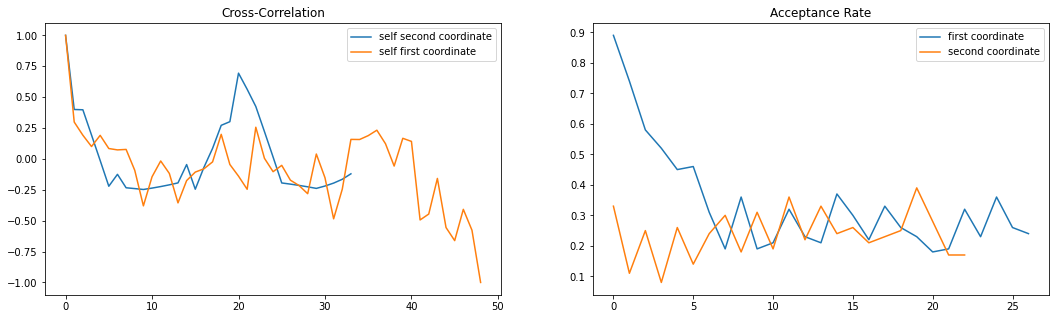

In [ ]:
sampler = AdaptativeSampler(vector = np.array([0,0]), initial_sigma = 3, goal_acceptance = 0.24, a = 10)

sampled_x, sampled_y = sampler.sample(nb_iterations_sampling = 100, nb_iterations_sampler = 50)
sampler.plot_history()

Here we observe that with adaptative variance, the self-correlation revolves more around the zero value than the previous algorithm. In the same manner, as expected, the acceptance rate of both coordinates is around 0.234 after a few iterations, as we decided to adapt the variance.

This algorithm thus seems to be more performing than the first algorithm.

### Question 1.B.2

We see the same behaviour on the banana-shaped distribution (I only checked the two first coordinates).

However, it seems more difficult to be stable around the goal acceptance rate.

In [ ]:
def banana_log_likelihood(x, B = 0.1):

  lg = 0
  lg += -np.sum(np.square(x[2:]))
  lg += -x[0]**2/200 - (x[1]+ B*(x[0]**2) - 100*B)**2/2
  return lg



class MH_Sampler_Banana(MH_Sampler):
  def log_likelihood(self, vector):
    return banana_log_likelihood(vector)
    


In [ ]:

class Sampler_Banana(Sampler):
  def __init__(self, vector , sigma, a = 10):
    self.sampler = MH_Sampler_Banana(vector, sigma)
    self.vector = vector
    self.sigma = [sigma]*len(vector)

    self.history = [vector]
    self.history_alpha = {i: [] for i in range(len(vector))}

        
class AdaptativeSampler_Banana(AdaptativeSampler):
  def __init__(self, vector , initial_sigma = 3, goal_acceptance = 0.24, a = 10):
    self.sampler = MH_Sampler_Banana(vector, initial_sigma)
    self.vector = vector
    self.logsigma = np.array([np.log(initial_sigma)]*len(vector))


    self.goal_acceptance = 0.24

    self.history = [vector]
    self.history_alpha = {i: [] for i in range(len(vector))}
    

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


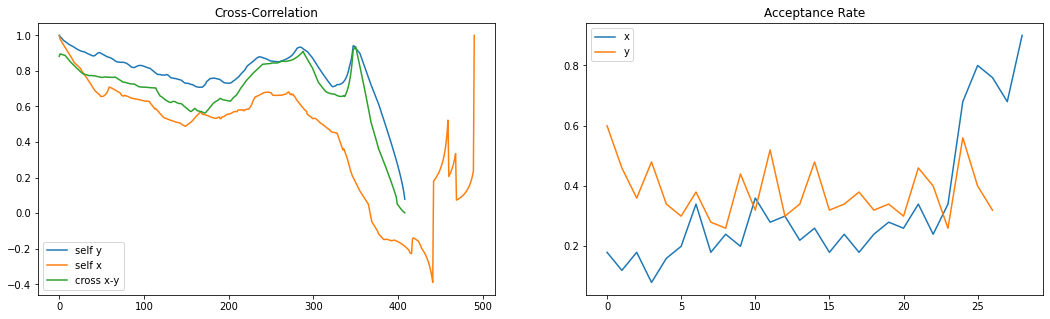

In [ ]:
sampler = Sampler_Banana(vector = np.array([0]*20), sigma = 3)

sample = sampler.sample(nb_iterations_sampling = 50, nb_iterations_sampler = 500)
sampler.plot_history()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


sigmas [0.97826696 1.72410975 1.5197564  1.50627079 1.55346771 1.52191599
 1.60623315 1.57674068 1.52355051 1.66596518 1.70110518 1.63421055
 1.70511653 1.54452166 1.68895924 1.85034704 1.56951663 1.53403083
 1.54286037 1.44546435]


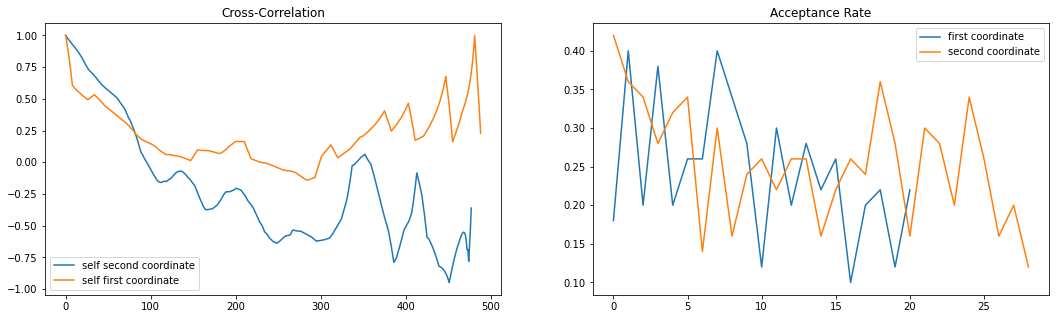

In [ ]:

sampler = AdaptativeSampler_Banana(vector = np.array([0]*20), initial_sigma = 3, goal_acceptance = 0.24, a = 10)

sample= sampler.sample(nb_iterations_sampling = 50, nb_iterations_sampler = 500)
sampler.plot_history()



---


## Exercise 2


### 2.A.1

First, I generate samples from the GMM.



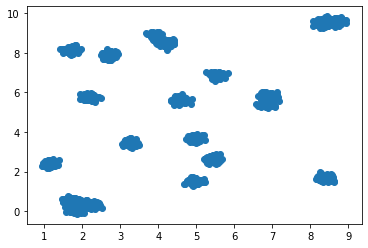

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def generate_X(xs, ps, nb =  1000):
  '''
  xs and ps are numpy arrays
  xs : n distinct real numbers
  ps : n distinct positive numbers summing to 1
  nb : number of samples drawn
  '''

  #first, sort the value
  arg_index = np.argsort(xs)
  xs = xs[arg_index]
  ps = ps[arg_index]
  
  #draw nb samples from uniform law
  us = np.random.uniform(size = nb)

  #compute the inverse of the CDF, here I use computation tricks, I hope it is faster
  cumsum_ps = np.cumsum(ps)
  cumsum_ps = np.tile(cumsum_ps,(nb,1))
  
  samples_index = np.sum(cumsum_ps <= us[:, np.newaxis], axis = 1)
  samples = xs[samples_index]

  return samples
  
n = 20
#n clusters


#define gaussian vectors law

mus = [[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[
3.93,8.82],[3.25,3.47],[
1.70,0.50],[
4.59,5.60],[
6.91,5.81],[
6.87,5.40],[
5.41,2.65],[
2.70,7.88],[
4.98,3.70],[
1.14,2.39],[
8.33,9.50],[
4.93,1.50],[
1.83,0.09],[
2.26,0.31],[
5.54,6.86],[
1.69,8.11]]

mus = np.array(mus)


L = 0.1*np.identity(2)


#STEP 1
p = np.ones(n)/n


X = np.arange(n) + 1

samples_Z = generate_X(X, p, nb = n*100)


#STEP 2
samples = [ np.random.multivariate_normal(np.zeros(2), 0.01*np.identity(2))   + mus[k-1,:] for k in samples_Z]
samples = np.array(samples)


plt.scatter(samples[:,0], samples[:,1])






Here, I defined the SRW-HM with adaptative variance and with fixed variance.

In [67]:
from scipy.special import logsumexp
def log_likelihood_GMM(x, mus = mus, sigma = 0.01):


  lg = mus - x[np.newaxis,:]

  lg = -np.einsum('ij,ij->i', lg,lg)/(2*sigma)


  return logsumexp(lg)



class MH_Sampler_GMM(MH_Sampler):
  def log_likelihood(self, vector):
    return log_likelihood_GMM(vector)
    


In [68]:

class Sampler_GMM(Sampler):
  def __init__(self, vector , sigma, a = 10):
    self.sampler = MH_Sampler_GMM(vector, sigma)
    self.vector = vector
    self.sigma = [sigma]*len(vector)

    self.history = [vector]
    self.history_alpha = {i: [] for i in range(len(vector))}

        
class AdaptativeSampler_GMM(AdaptativeSampler):
  def __init__(self, vector , initial_sigma = 3, goal_acceptance = 0.24, a = 10):
    self.sampler = MH_Sampler_GMM(vector, initial_sigma)
    self.vector = vector
    self.logsigma = np.array([np.log(initial_sigma)]*len(vector))


    self.goal_acceptance = 0.24

    self.history = [vector]
    self.history_alpha = {i: [] for i in range(len(vector))}
    

### 2.A.2

[]

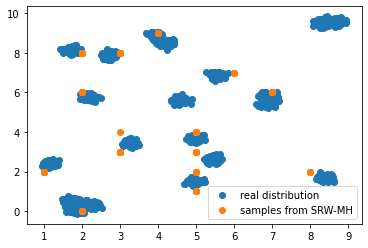

In [69]:
samples_toy = []


for j in range(1000):
  sampler = AdaptativeSampler_GMM(vector = np.array([0,0]), initial_sigma = 3, goal_acceptance = 0.24, a = 10)
  samples_toy.append(sampler.sample(nb_iterations_sampling = 5, nb_iterations_sampler = 25))

samples_toy = np.array(samples_toy)

plt.scatter(samples[:,0], samples[:,1], label = 'real distribution')
plt.scatter(samples_toy[:,0], samples_toy[:,1], label = 'samples from SRW-MH')
plt.legend()
plt.plot()


[]

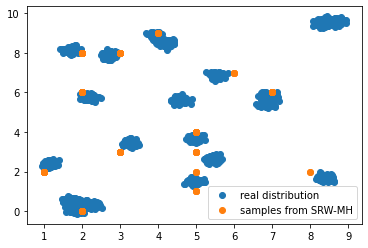

In [70]:
samples_toy = []


for j in range(1000):
  sampler = Sampler_GMM(vector = np.array([0,0]), sigma = 3)
  samples_toy.append(sampler.sample(nb_iterations_sampling = 5, nb_iterations_sampler = 20))

samples_toy = np.array(samples_toy)

plt.scatter(samples[:,0], samples[:,1], label = 'real distribution')
plt.scatter(samples_toy[:,0], samples_toy[:,1], label = 'samples from SRW-MH')
plt.legend()
plt.plot()


Although I sampled 1000 samples, the samples doesn't find all modes and even if they find them, they don't seem to be covering well the modes.

Moreover, it is really slow.

### 2.B.1

In [213]:

class ParallelTemperingSampler():
  '''
  Parallel Tempering
  '''
  def __init__(self, init_vector, temp):
    '''
    init_vector = shape (K, 2)
    temp = shape (K)
    '''
    self.vector = init_vector
    self.K = len(self.vector)
    self.temp = temp
    self.variance = temp/16
    self.compteur = 0
    self.compteur_acceptance = 0

    

  def reinitialisation(self, vector):
    self.vector = vector
    self.compteur = 0
    self.compteur_acceptance = 0

  
  def sample(self, index):
    vector_drawn = np.random.multivariate_normal(self.vector[index,:], self.variance[index]*np.identity(2))
    
    return vector_drawn
  
  def draw_i_j(self):
    # j = i +/- 1
    #first draw among +/- 1 then among the K-1 possibilities for i

    sign = np.random.binomial(1,0.5)
    if sign == 0:
      i = np.random.randint(0,self.K-1)
      j = i + 1
    else:
      i = np.random.randint(1,self.K)
      j = i - 1
    return i,j

  def log_likelihood(self, vector, index):  
    return (1/self.temp[index])*log_likelihood_GMM(vector)

    

  def step(self):
    #sample
    vector_drawn = []
    for index in range(self.K):
      vector_drawn.append(self.sample(index))

    vector_drawn = np.array(vector_drawn)

    i,j = self.draw_i_j()
    #acceptance_rejectance
    lg = self.log_likelihood(vector_drawn[i,:],i) +  self.log_likelihood(vector_drawn[j,:],j)

    lg_proposal = self.log_likelihood(vector_drawn[i,:],j) + self.log_likelihood(vector_drawn[j,:],i)

    alpha = min(0, (lg_proposal - lg))
    
    u = np.log(np.random.uniform())
    self.vector = vector_drawn.copy()
    #acceptance
    if u<=alpha:
      self.compteur_acceptance += 1
      self.vector[[i,j],:] = vector_drawn[[j,i], :]

      
    
    self.compteur += 1

    return self.vector

Done
iteration 40001
Current acceptance rate 1.3024348782560873


[]

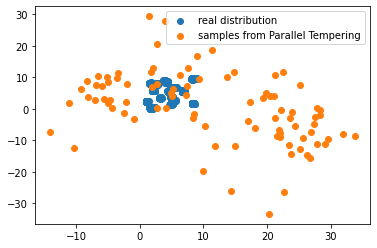

In [214]:
from IPython.display import clear_output

samples_PT = []

K = 5
temp = np.array([60,21.6, 7.7, 2.8, 1])

init_vectors = np.ones((K, 2))

sampler = ParallelTemperingSampler(init_vectors, temp)

for j in range(40002):
  s = sampler.step()
  if j%400 == 1 and j > 5000:
    clear_output(wait = True)
    print("Done")
    print("iteration", j)
    print("Current acceptance rate", (sampler.compteur_acceptance/sampler.compteur)*100)
    samples_PT.append(s)




samples_PT = np.array(samples_PT)

plt.scatter(samples[:,0], samples[:,1], label = 'real distribution')
plt.scatter(samples_PT[:, -1 ,0], samples_PT[:, -1,1], label = 'samples from Parallel Tempering')
plt.legend()
plt.plot()


[]

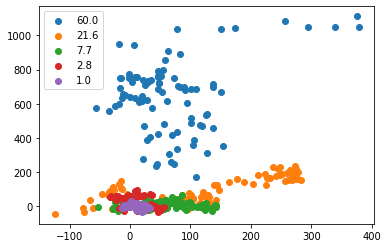

In [216]:
for i,t in enumerate(temp): 
  plt.scatter(samples_PT[:,i,0], samples_PT[:,i,1], label = t)
plt.legend()
plt.plot()


**Observations:** It doesn't seem to work well, even though it does explorate more, I must have done something wrong.

I wonder if I computed rightly the acceptance rates or if I should do an adaptative MH as the acceptance rate is quite low.

## Exercise 3

### Question 1

$Π(Y,X,\mu,σ^2, τ^2) = Π(Y |X,\mu,σ^2, τ^2) Π(X|\mu,σ^2, τ^2) Π(\mu,σ^2, τ^2)$.

We already know each term : 

$$Π(Y |X,\mu,σ^2, τ^2) = \prod_{i,j} \mathcal{N}_{X_i, \tau^2}(Y_{i,j}) $$

$$Π(X|\mu,σ^2, τ^2) = \prod_{i} \mathcal{N}_{\mu, \sigma^2}(X_{i}) $$

$$Π(\mu,σ^2, τ^2) = \pi_{prior}(\mu,σ^2, τ^2)$$



## Question 2

Let's note $\Gamma^{-1}(a,b)$ the inverse Gamma distribution with parameters a and b.


For  $\mu$, 
$Π(\mu|X,Y,σ^2, τ^2)$ is proportionnal to $Π(Y,X,\mu,σ^2, τ^2)$ which in turns only rely on μ in the following term  :
$$\prod_{i}exp( -(X_i-\mu)^2/(2\sigma^2))$$
$$=\exp(\sum_i -(X_i-\mu)^2/(2\sigma^2))$$
$$\propto exp(- (N\mu^2 - 2\mu\sum_iX_i) /(2\sigma^2))$$
$$\propto exp(- (\mu^2 - \sum_iX_i/N)^2 /(2\sigma^2/N))$$

So: 
$$\mu |Y,X,\mu,σ^2, τ^2 \sim \mathcal{N}_{\bar X, \sigma^2/n}$$.

In the same manner, 

$$σ^2 | Y,X,\mu,τ^2 \sim \Gamma^{-1}(\alpha + N/2,\beta + \sum_i(X_i-\mu)^2/2)$$
$$\tau^2 | Y,X,\mu,\sigma^2 \sim \Gamma^{-1}(\gamma + \sum_ik_i/2,\beta + \sum_{i,j} (X_i - Y_{i,j})^2/2)$$
$$X_{i} |Y,\mu,σ^2, τ^2 \sim \mathcal{N}(\frac{\frac{\mu}{\sigma^2} + \frac{\bar Y_i}{\tau^2/k_i}}{\frac{1}{\sigma^2} + \frac{1}{\tau^2/k_i}}, \frac{1}{\frac{1}{\sigma^2} + \frac{1}{\tau^2/k_i}})$$

In [43]:
import numpy as np
import scipy
from scipy.stats import norm


def draw_from_normal_distr(shape, mu, sigma):
  rv = scipy.stats.norm(loc = mu, scale = sigma)
  return rv.rvs(shape)

def draw_from_gammaInv_distr(shape, a, b):
  
  return 1/np.random.gamma(a, 1/b,shape)

class GibbsSampler():
  def __init__(self, Y, X, sigma, tau, mu, alpha, beta, gamma):
    '''
    Y: shape (N,k) - realization
    X: array of size N - initial guess
    sigma corresponds to sigma_squared - initial guess
    tau corresponds to tau_squared - initial guess
    mu - initial guess
    '''
    self.N, self.k = Y.shape
    self.Y = Y
    self.X = X
    self.sigma = sigma
    self.tau = tau
    self.mu = mu
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma

  def sample_sigma(self):
    alpha = self.alpha + self.N/2
    beta = self.beta + np.sum(np.square(self.X-self.mu))/2
    self.sigma = draw_from_gammaInv_distr(1, alpha, beta)[0]
  
  def sample_tau(self):
    alpha = self.alpha + self.N*self.k/2
    beta = self.gamma + np.sum(np.square(self.X[:, np.newaxis]-self.Y))/2
    self.tau = draw_from_gammaInv_distr(1, alpha, beta)[0]

  def sample_mu(self):
    
    moy = np.mean(self.X)
    sd = np.sqrt(self.sigma/self.N)
    self.mu = draw_from_normal_distr(1, moy, sd)[0]
    
  
  def sample_X(self):
    Y_i = np.mean(self.Y, axis = 1)
    tau_weight = self.tau/self.k

    moy = (self.mu/self.sigma + Y_i/tau_weight)/(1/self.sigma + 1/tau_weight)
    sigma = 1/(1/self.sigma + 1/tau_weight)


    self.X = np.random.multivariate_normal(moy, sigma*np.identity(self.N))

  def step(self):
    self.sample_sigma()
    self.sample_tau()
    self.sample_mu()
    self.sample_X()


### Question 3


Likewise, 

 $Π(\mu,X|Y,σ^2, τ^2) \propto$
$$\prod_{i}exp( -(X_i-\mu)^2/(2\sigma^2))*\prod_{i,j}exp( -(X_i-Y_{i,j})^2/(2\tau^2))$$
$$\propto \exp(-\sum_{i,j} (\delta_{i=j}(X_i-\mu)^2/(2\sigma^2)) + (X_i-Y_{i,j})^2/(2\tau^2)))$$

$$\propto \exp(-\sum_{i} ((X_i-\mu)^2/(2\sigma^2) + (X_i-\bar Y_{i})^2/(2\tau^2/k_i)))$$ 
> this latter computation relies on the same kind of computation I did to find the conditional law of μ.

$$\propto \exp(-\frac{1}{2}\sum_{i} X_i^2/\sigma^2  + \mu^2/\sigma^2 - 2X_i\mu/\sigma^2 + X_i^2/\frac{\tau^2}{k_i}+\bar Y_{i}^2/\frac{\tau^2}{k_i} -2\bar Y_i X_i/\frac{\tau^2}{k_i})$$ 

We want to find $m$ and $Σ$ such that the previous exponential is equivalent to $e^{-(Z- m)^TΣ^{-1}(Z-m)/2} = e^{-\sum_{i,j} s_{i,j}(z_i - m_i)(z_j -m_j)/2}$ where $Z = (X^T,\mu)^T$ and $\Sigma^{-1}= [s_{i,j}]_{i,j}$.

By identification, we have the system:
\begin{cases}
      s_{i,i} = \frac{1}{σ^2} + \frac{1}{\tau^2/k_i} & \text{for i < N +1}\\
      s_{N+1,N+1} = \frac{1}{σ^2} \\
      s_{i,N+1} = s_{N+1,i} =  -\frac{1}{σ^2} & \text{for i < N +1}\\
      m_i = {\bar Y}_i \frac{1}{\tau^2/k_i}/s_{i,i} = \frac{\bar Y_i \sigma^2 k_i}{\tau^2 + \sigma^2k_i} & \text{for i < N +1}\\
      m_{N+1} = s_{i,j} = 0 & \text{otherwise}
\end{cases} 









In [44]:

class BlockGibbsSampler():
  def __init__(self, Y, X, sigma, tau, mu, alpha, beta, gamma):
    '''
    Y: shape (N,k) - realization
    X: array of size N - initial guess
    sigma corresponds to sigma_squared - initial guess
    tau corresponds to tau_squared - initial guess
    mu - initial guess
    '''
    self.N, self.k = Y.shape
    self.Y = Y
    self.X = X
    self.sigma = sigma
    self.tau = tau
    self.mu = mu
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma

  def sample_sigma(self):
    alpha = self.alpha + self.N/2
    beta = self.beta + np.sum(np.square(self.X-self.mu))/2
    self.sigma = draw_from_gammaInv_distr(1, alpha, beta)[0]
  
  def sample_tau(self):
    alpha = self.alpha + self.N*self.k/2
    beta = self.gamma + np.sum(np.square(self.X[:, np.newaxis]-self.Y))/2
    self.tau = draw_from_gammaInv_distr(1, alpha, beta)[0]

  def sample_X_mu(self):
    
    Y_i = np.mean(self.Y, axis = 1)
    tau_weight = self.tau/self.k

    inv_var = 1/self.sigma + 1/tau_weight
    moy = Y_i/(inv_var*tau_weight)

    #shape N+1
    moy = np.append(moy,0)
    sigma_inv = np.diag([inv_var]*self.N + [1/self.sigma])
    for i in range(self.N):
      sigma_inv[i,self.N] = -sigma_inv[self.N,self.N]
      sigma_inv[self.N,i] = -sigma_inv[self.N,self.N]

    sigma = np.linalg.inv(sigma_inv) + np.identity(self.N+1)*1e-5

    samples = np.random.multivariate_normal(moy, sigma)

    self.X = samples[:self.N]
    self.mu = samples[-1]


  def step(self):
    self.sample_sigma()
    self.sample_tau()
    self.sample_X_mu()


### Question 4



The first algorithm is simpler in terms of complexity, since we only draw from distributions that we know are fast and efficient (normal and gamma distributions). 
The second algorithm is a little more complicate since we have to draw from a gaussian vector. We can simplify it by computing by hand the inverse of $\Sigma^{-1}$ since it has a form which is convenient for the inverse computation (diagonal + sparse matrices) - I didn't do the computation but I think it is possible.

Moreover, it seems to me that $\mu$ has a different role in both algorithm. Whereas in the first algorithm, it keeps track of $\bar X =\sum_iX_i$, in the second algorithm, the expectation of $\mu$ is 0. Indeed, in the second algorithm, $\mu$ only helps by imposing dependence between the $X_i$ (the covariance matrix is no longer diagonal, the dependence to $\mu$ imposes a correlation between the $X_i$).  

One may wonder why $\mu$ has a different role in both sampling. My guess is that $\mu$ is a free parameter with a degenerate behaviour since it has no distribution (it is uniform on the real space, which doesn't make any mathematical sense). So, whereas it has a sense *a posteriori* as the mean of the $X_i$, it has a different meaning *a priori* as a regularizer of the $X_i$ covariance. 

### Question 5


In [50]:
# First, create the synthetic dataset

real_alpha = 2
real_beta = 0.5
real_gamma = 2

N = 10
k = 50

real_sigma = draw_from_gammaInv_distr(1,real_alpha, real_beta)[0]
real_tau = draw_from_gammaInv_distr(1,real_gamma, real_beta)[0]
real_mu = 5

real_X = draw_from_normal_distr(N, real_mu, real_sigma)

noise = draw_from_normal_distr((N,k), 0, real_tau)

real_Y = real_X[:, np.newaxis] + noise





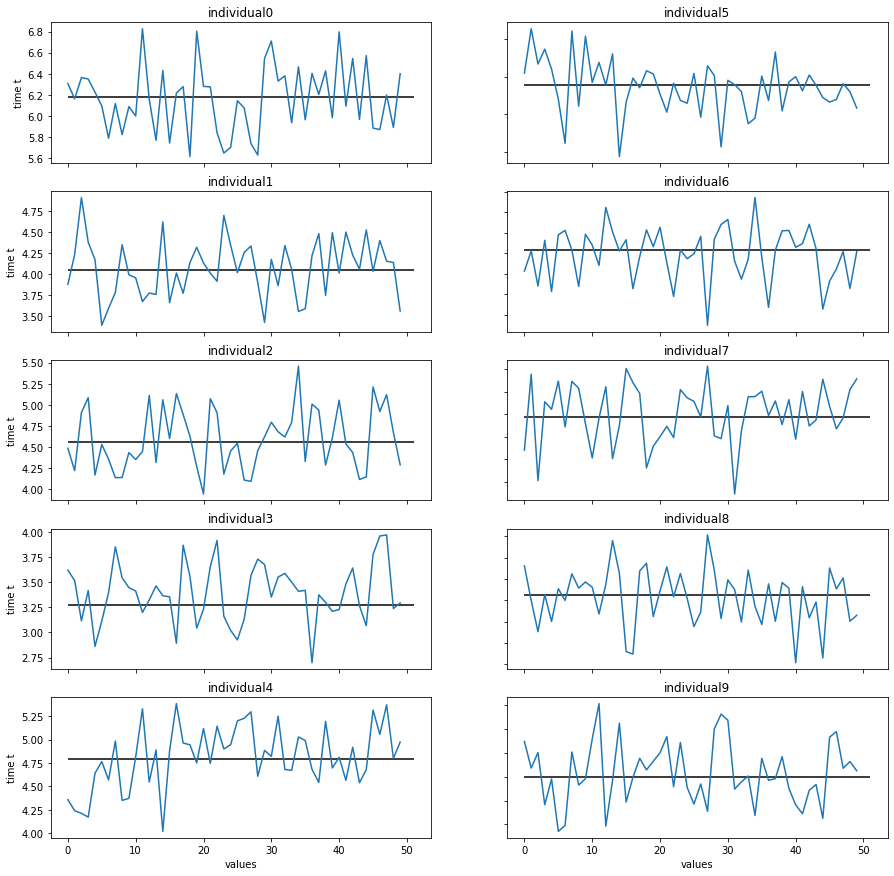

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(5):
  for j in range(2):
    axs[i,j].plot(real_Y[5*j+i])
    axs[i,j].hlines(real_X[5*j+i], 0, k+1)
    axs[i,j].set_title('individual' + str(5*j+i))


for ax in axs.flat:
    ax.set(xlabel='values', ylabel='time t')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [52]:
gibbsSampler = GibbsSampler(real_Y, np.mean(real_Y, axis = 1), np.var(real_Y), 0.4, np.mean(real_Y), real_alpha, real_beta, real_gamma)
blockgibbsSampler = BlockGibbsSampler(real_Y, np.mean(real_Y, axis = 1), np.var(real_Y), 0.4, np.mean(real_Y), real_alpha, real_beta, real_gamma)

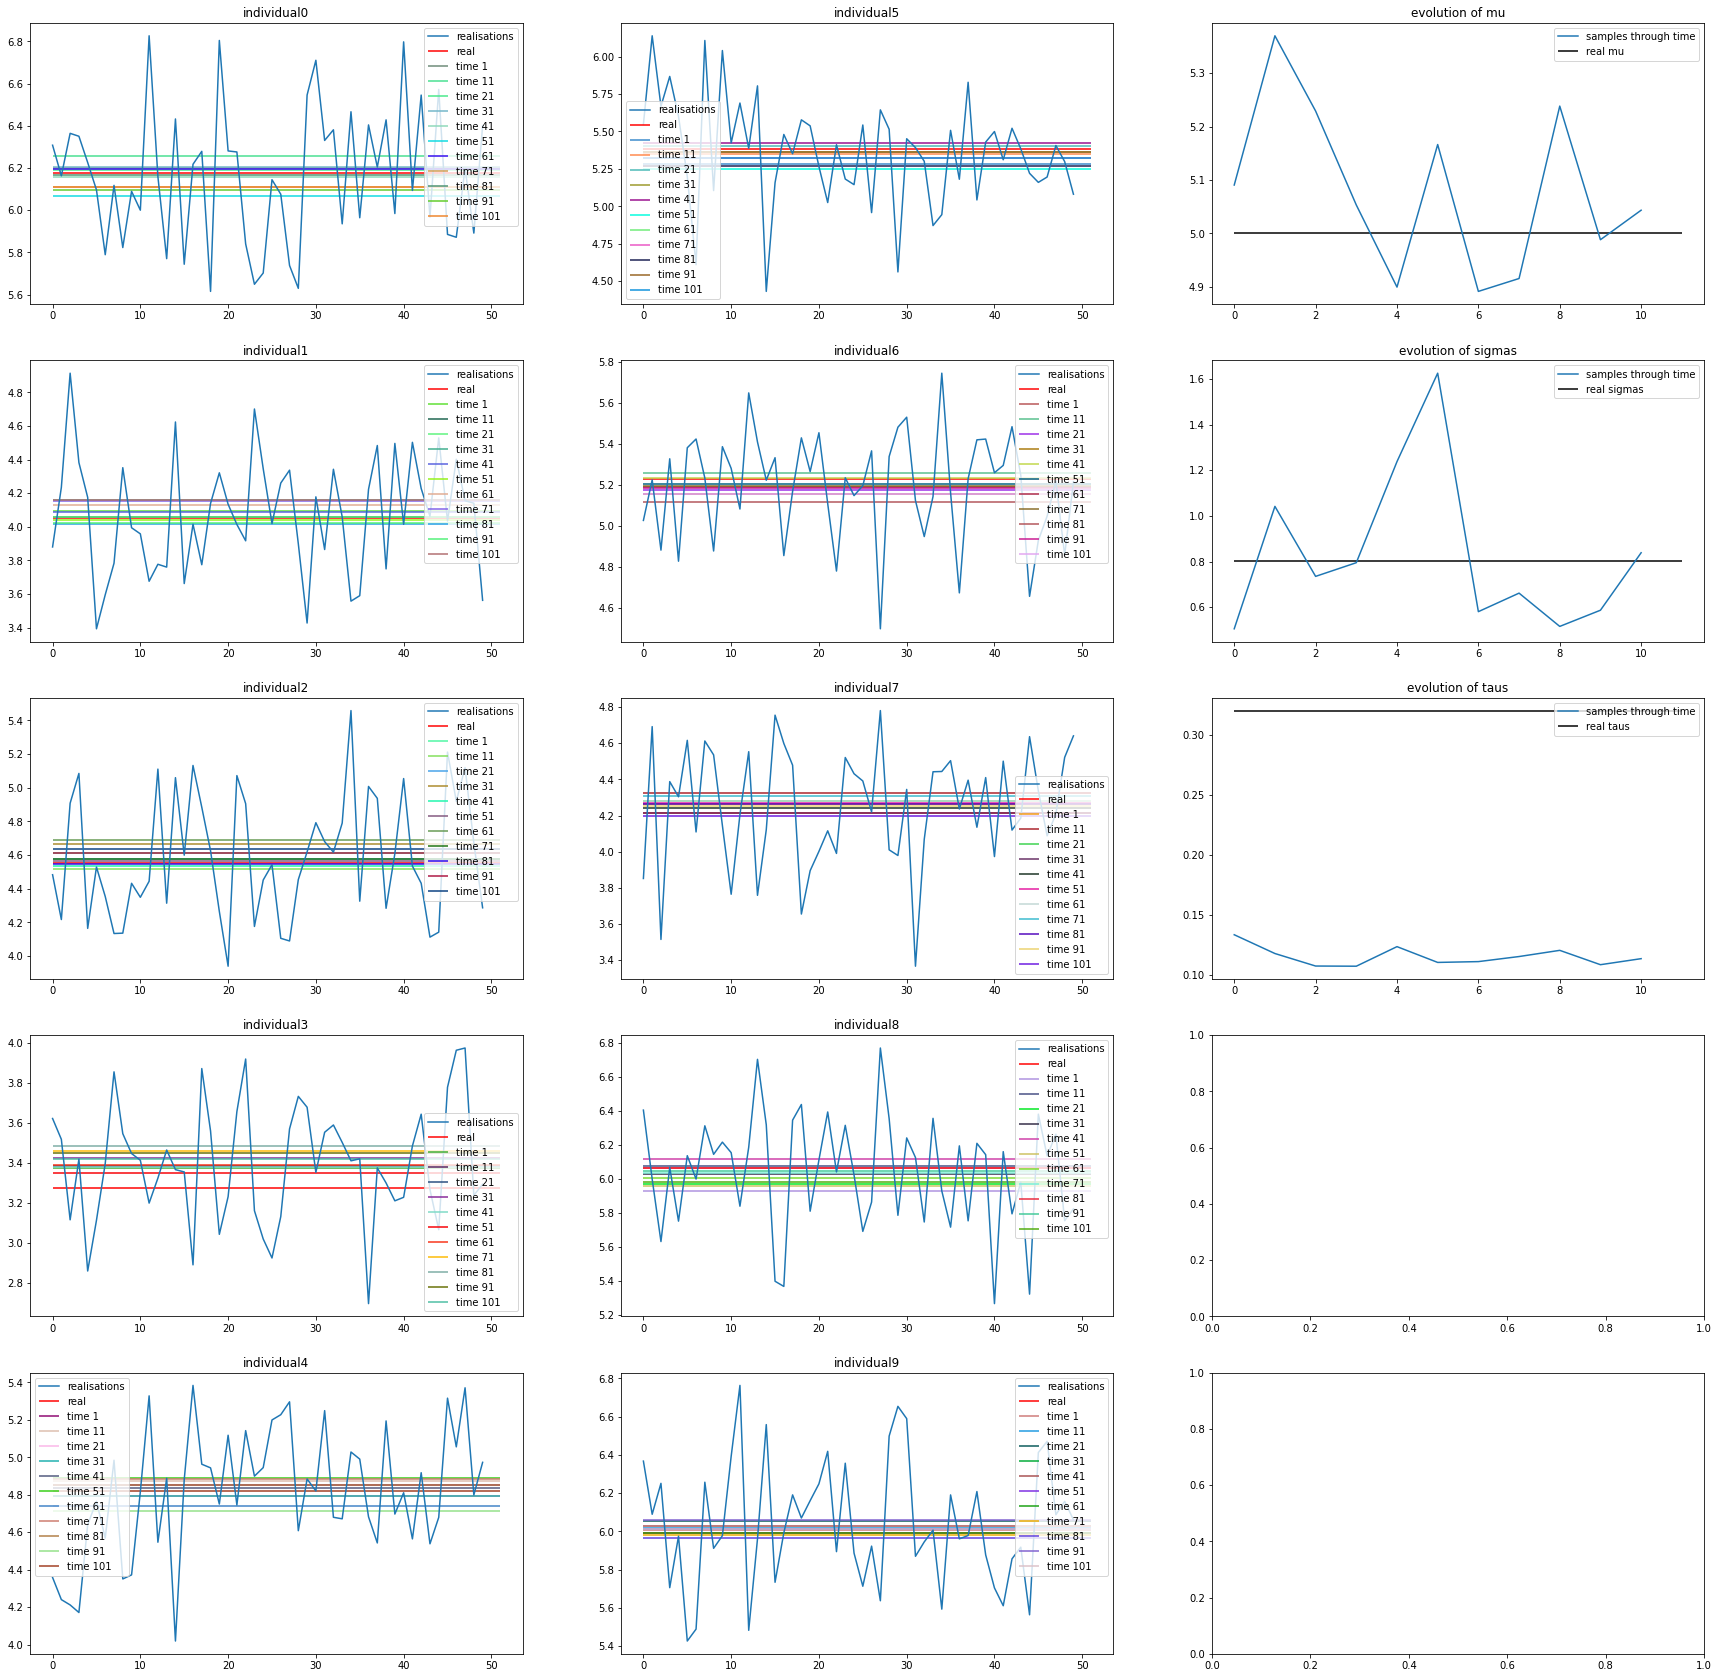

In [53]:
import random
nb_iter = 102


fig, axs = plt.subplots(5,3)
fig.set_figheight(30)
fig.set_figwidth(30)

for i in range(5):
  for j in range(2):
    axs[i,j].plot(real_Y[5*j+i], label = "realisations")
    axs[i,j].hlines(real_X[5*j+i], 0, k+1, label = 'real', color = 'red')
    axs[i,j].set_title('individual' + str(5*j+i))

X = []
mus = []
sigmas = []
taus = []

for t in range(nb_iter):
  gibbsSampler.step()
  if t%10 == 1:
    X.append(gibbsSampler.X)
    mus.append(gibbsSampler.mu)
    sigmas.append(gibbsSampler.sigma)
    taus.append(gibbsSampler.tau)
    for i in range(5):
      for j in range(2):
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        axs[i,j].hlines(X[-1][5*j+i], 0, k+1, label = 'time ' + str(t), color = color)
        axs[i,j].legend()

axs[0,2].plot(mus, label = 'samples through time')
axs[0,2].hlines(real_mu,0, len(mus), label = "real mu")
axs[0,2].set_title('evolution of mu')
axs[0,2].legend()

axs[1,2].plot(sigmas, label = 'samples through time')
axs[1,2].hlines(real_sigma,0, len(sigmas), label = "real sigmas")
axs[1,2].set_title('evolution of sigmas')
axs[1,2].legend()

axs[2,2].plot(taus, label = 'samples through time')
axs[2,2].hlines(real_tau,0, len(taus), label = "real taus")
axs[2,2].set_title('evolution of taus')
axs[2,2].legend()



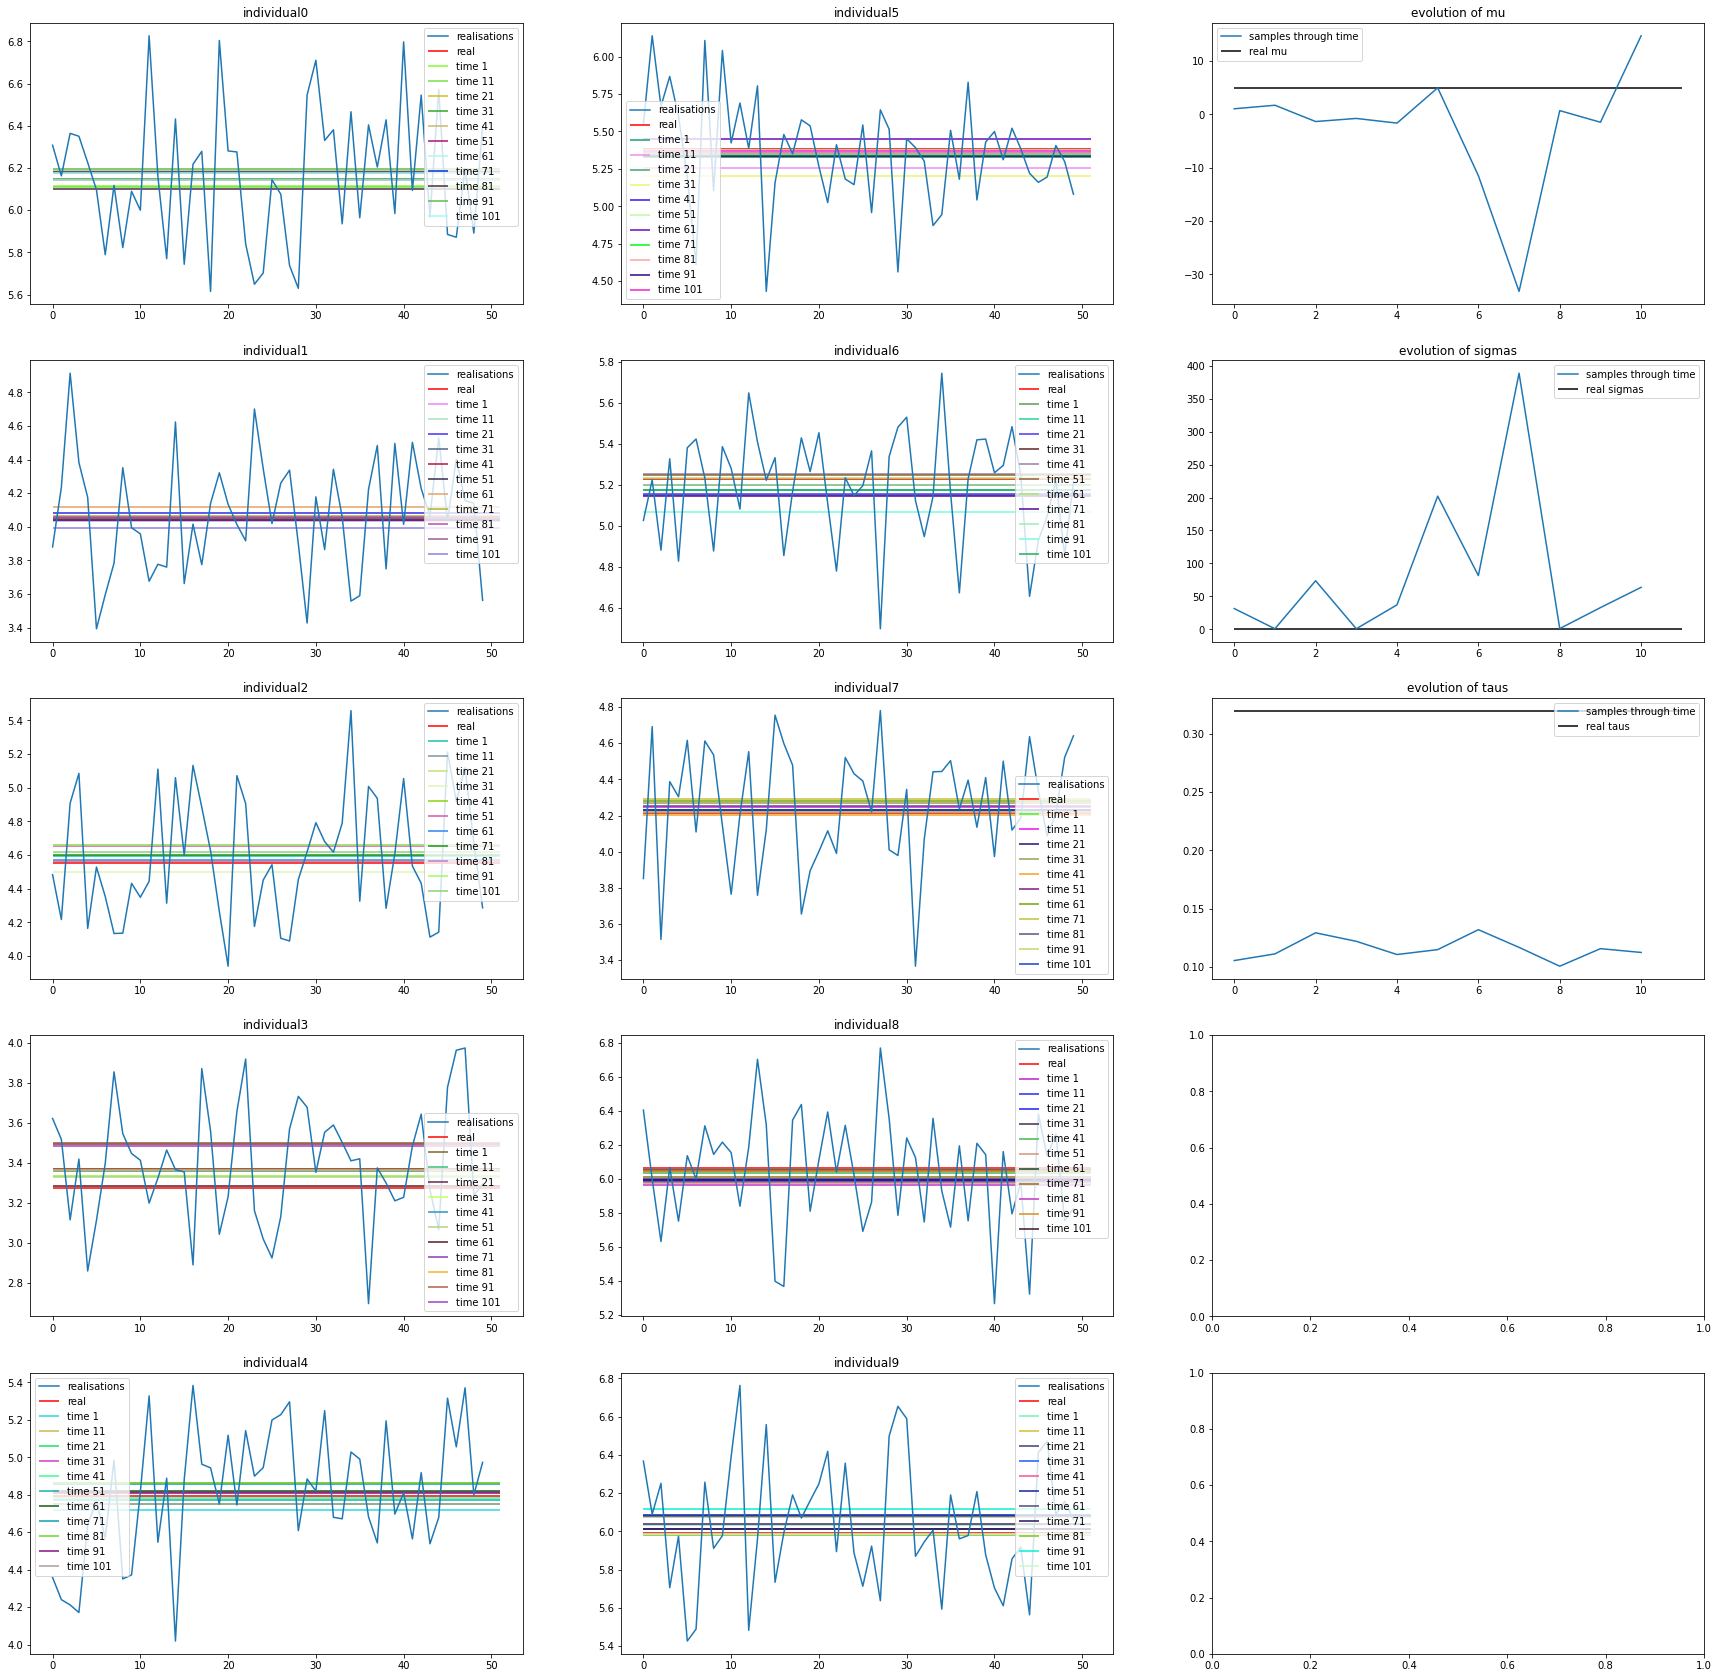

In [54]:
import random
nb_iter = 102


fig, axs = plt.subplots(5,3)
fig.set_figheight(30)
fig.set_figwidth(30)

for i in range(5):
  for j in range(2):
    axs[i,j].plot(real_Y[5*j+i], label = "realisations")
    axs[i,j].hlines(real_X[5*j+i], 0, k+1, label = 'real', color = 'red')
    axs[i,j].set_title('individual' + str(5*j+i))

X = []
mus = []
sigmas = []
taus = []

for t in range(nb_iter):
  blockgibbsSampler.step()
  if t%10 == 1:
    X.append(blockgibbsSampler.X)
    mus.append(blockgibbsSampler.mu)
    sigmas.append(blockgibbsSampler.sigma)
    taus.append(blockgibbsSampler.tau)
    for i in range(5):
      for j in range(2):
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        axs[i,j].hlines(X[-1][5*j+i], 0, k+1, label = 'time ' + str(t), color = color)
        axs[i,j].legend()

axs[0,2].plot(mus, label = 'samples through time')
axs[0,2].hlines(real_mu,0, len(mus), label = "real mu")
axs[0,2].set_title('evolution of mu')
axs[0,2].legend()

axs[1,2].plot(sigmas, label = 'samples through time')
axs[1,2].hlines(real_sigma,0, len(sigmas), label = "real sigmas")
axs[1,2].set_title('evolution of sigmas')
axs[1,2].legend()

axs[2,2].plot(taus, label = 'samples through time')
axs[2,2].hlines(real_tau,0, len(taus), label = "real taus")
axs[2,2].set_title('evolution of taus')
axs[2,2].legend()

